In [1]:
from google.colab import drive
drive.mount('/content/drive')
# drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend
import tensorflow.keras.layers
import tensorflow.keras.models
import time
import sys
import os

In [3]:
data_train = pd.read_csv('/content/drive/MyDrive/lish-moa/train_features.csv')
data_test = pd.read_csv('/content/drive/MyDrive/lish-moa/test_features.csv')
targetns = pd.read_csv('/content/drive/MyDrive/lish-moa/train_targets_nonscored.csv')
targetscored = pd.read_csv('/content/drive/MyDrive/lish-moa/train_targets_scored.csv')
data_train

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,-0.2102,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,-1.1800,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,-1.6740,...,-2.1220,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,-0.7110,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,trt_cp,24,D2,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,-0.4726,0.1269,0.2531,0.1730,-0.4532,-1.0790,0.2474,-0.4550,0.3588,0.1600,-0.7362,-0.1103,0.8550,-0.4139,0.5541,0.2310,-0.5573,-0.4397,-0.9260,-0.2424,-0.6686,0.2326,0.

In [4]:
target_cols = targetscored.columns[1:]
# N_TARGETS = len(target_cols)
print(data_train.shape)
print(data_test.shape)
print(targetns.shape)
print(targetscored.shape)

(23814, 876)
(3982, 876)
(23814, 403)
(23814, 207)


In [5]:
cells = [col for col in data_train.columns if col.startswith('c-')]
genes = [col for col in data_train.columns if col.startswith('g-')]

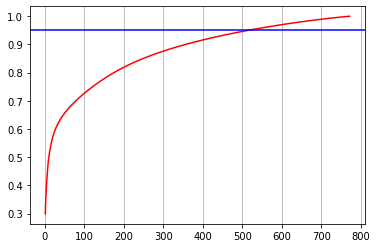

In [6]:
#Deciding the number of components for gene features
data = pd.concat([pd.DataFrame(data_train[genes]), pd.DataFrame(data_test[genes])])
pca = PCA().fit(data)
xi = np.arange(1, 773, 1)
y = np.cumsum(pca.explained_variance_ratio_)
plt.plot(xi, y, color = 'red')
plt.axhline(y = 0.95, color = 'blue')
plt.grid(axis = 'x')

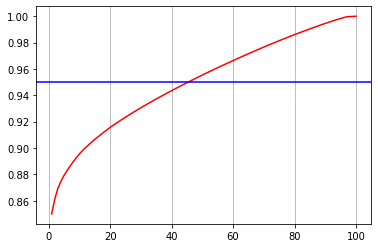

In [7]:
#Deciding the number of components for cell features
data = pd.concat([pd.DataFrame(data_train[cells]), pd.DataFrame(data_test[cells])])
pca = PCA().fit(data)
xi = np.arange(1, 101, 1)
y = np.cumsum(pca.explained_variance_ratio_)
plt.plot(xi, y, color = 'red')
plt.axhline(y = 0.95, color = 'blue')
plt.grid(axis = 'x')

In [8]:
# For g- features
data = pd.concat([pd.DataFrame(data_train[genes]), pd.DataFrame(data_test[genes])])
data_pca = (PCA(n_components = 525, random_state = 100).fit_transform(data[genes]))
train_pca = data_pca[:data_train.shape[0]]
test_pca = data_pca[-data_test.shape[0]:]

train_pca = pd.DataFrame(train_pca, columns = [f'pca_G-{i}' for i in range(525)])
test_pca = pd.DataFrame(test_pca, columns = [f'pca_G-{i}' for i in range(525)])

data_train = pd.concat((data_train, train_pca), axis = 1)
data_test = pd.concat((data_test, test_pca), axis = 1)

In [9]:
# For c- features
data = pd.concat([pd.DataFrame(data_train[cells]), pd.DataFrame(data_test[cells])])
data_pca = (PCA(n_components = 45, random_state = 100).fit_transform(data[cells]))
train_pca = data_pca[:data_train.shape[0]]
test_pca = data_pca[-data_test.shape[0]:]

train_pca = pd.DataFrame(train_pca, columns = [f'pca_C-{i}' for i in range(45)])
test_pca = pd.DataFrame(test_pca, columns = [f'pca_C-{i}' for i in range(45)])
data_train = pd.concat((data_train, train_pca), axis = 1)
data_test = pd.concat((data_test, test_pca), axis = 1)
# data_train

In [10]:
train_copy = data_train
var_thresh = VarianceThreshold(0.8)
data = data_train.append(data_test)
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])
data_transformed

array([[ 1.062     , -0.2479    , -0.6208    , ..., -0.88945237,
         0.52050405, -0.41983391],
       [ 0.0743    ,  0.2991    ,  0.0604    , ...,  0.22471968,
         0.94895294, -0.05855933],
       [ 0.628     ,  1.554     , -0.0764    , ..., -0.13469001,
        -0.2249024 ,  0.16776555],
       ...,
       [-0.3985    ,  0.2677    , -0.6813    , ..., -0.12958965,
        -0.27791464,  0.999736  ],
       [-1.096     , -0.3977    ,  1.016     , ..., -0.10545347,
         0.01487324, -0.08750892],
       [-0.5174    ,  0.3286    , -0.0428    , ..., -0.47032949,
         0.35373542, -0.21689743]])

In [11]:
train_df_trans = data_transformed[ : data_train.shape[0]]
test_df_trans = data_transformed[-data_test.shape[0] : ]

data_train = pd.DataFrame(data_train[['sig_id', 'cp_type', 'cp_time', 'cp_dose']].
                        values.reshape(-1, 4), columns = ['sig_id', 'cp_type', 
                                                          'cp_time', 'cp_dose'])
# data_train.head
data_train = pd.concat([data_train, pd.DataFrame(train_df_trans)], axis = 1)


data_test = pd.DataFrame(data_test[['sig_id', 'cp_type', 'cp_time', 'cp_dose']].
                       values.reshape(-1, 4), columns = ['sig_id', 'cp_type', 
                                                         'cp_time', 'cp_dose'])
# data_train.head
data_test = pd.concat([data_test, pd.DataFrame(test_df_trans)], axis = 1)
# data_train.head

In [13]:
def preprocess_df(data):
  # data['cp_type'] = (data['cp_type'] == 'trt_cp').astype(int)
  # data['cp_dose'] = (data['cp_dose'] == 'D2').astype(int)
  data.drop(['cp_type'], axis = 1, inplace = True)
  data.loc[:, 'cp_dose'] = data.loc[:, 'cp_dose'].map({'D1':0, 'D2':1})
  data.loc[:, 'cp_time'] = data.loc[:, 'cp_time'].map({24:0, 48:1, 72:2})
  return data

In [14]:
x_train = preprocess_df(data_train.drop(columns = "sig_id"))
x_test = preprocess_df(data_test.drop(columns = "sig_id"))
y_train = targetscored.drop(columns = "sig_id")
y_test = targetns.drop(columns = "sig_id")
print(y_test.shape)
N_FEATURES = x_train.shape[1]

(23814, 402)


In [15]:
x_train = x_train.astype({'cp_time':int})
x_test = x_test.astype({'cp_time':int})
x_train_validation = x_train.copy()
# x_train

In [16]:
def create_model(col_num):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(col_num))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(6144, 
                                                                 activation = "relu")))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(6144, 
                                                                 activation = "relu")))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(206, 
                                                                 activation = "sigmoid")))
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005), 
                loss = 'binary_crossentropy', metrics = ["accuracy"])
  return model

In [17]:
def build_train(repeat_number = 0, folds = 5):
  models = []
  predicted_values = y_train.copy()
  kfold = KFold(n_splits = folds, shuffle = True)
  for fold, (ti, vi) in enumerate(kfold.split(x_train)):
    print('Training fold: ', fold)
    model_save = f'model:{repeat_number}_{fold}.hdf5'
    callback_1 = tf.keras.callbacks.ModelCheckpoint(model_save, 
                                                    monitor = 'val_loss', 
                                                    verbose = 2,
                                                    save_best_only = True, 
                                                    save_weights_only = True, 
                                                    mode = 'min')
    
    callback_2 = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', 
                                                          factor = 0.4, 
                                                          patience = 2, 
                                                          verbose = 1, 
                                                          min_delta = 0.0001, 
                                                          mode = 'auto')   
    
    # callback_3 = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
    #                                               verbose = 2, mode = 'max', 
    #                                               min_delta = 0.01)

    model = create_model(N_FEATURES)
    training_history = model.fit(x_train.values[ti], 
                                 y_train.values[ti], 
              validation_data = (x_train.values[vi], y_train.values[vi]),
              callbacks = [callback_1, callback_2], epochs = 20, 
              batch_size = 128, verbose = 2)
    model.load_weights(model_save)
    predicted_values.loc[vi, :] = model.predict(x_train.values[vi])
    models.append(model)
    print('train:')
    print(list(zip(model.metrics_names, model.evaluate(x_train.values[ti], 
                                                       y_train.values[ti], 
                                                       verbose = 0, 
                                                       batch_size = 32))))
    print('val:')
    print(list(zip(model.metrics_names, model.evaluate(x_train.values[vi], 
                                                       y_train.values[vi], 
                                                       verbose = 0, 
                                                       batch_size = 32))))
    return models, predicted_values, training_history
  

In [18]:
model = create_model(col_num = N_FEATURES)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
weight_normalization (Weight (None, 6144)              12601345  
_________________________________________________________________
batch_normalization_1 (Batch (None, 6144)              24576     
_________________________________________________________________
dropout_1 (Dropout)          (None, 6144)              0         
_________________________________________________________________
weight_normalization_1 (Weig (None, 6144)              75515905  
_________________________________________________________________
batch_normalization_2 (Batch (None, 6144)              2

In [21]:
models = []
all_predicted = []
np.random.seed(11)
os.environ['PYTHONHASHSEED'] = str(11)
tf.random.set_seed(11)
# SEED_ARRAY = [0, 1, 2, 3, 4]
for i in range(5):
  m_temp, pred_new, history = build_train(repeat_number = i, folds = 5)  
  all_predicted.append(pred_new)
  models = models + m_temp

Training fold:  0
Epoch 1/20

Epoch 00001: val_loss improved from inf to 0.10237, saving model to model:0_0.hdf5
149/149 - 8s - loss: 0.4571 - accuracy: 0.0454 - val_loss: 0.1024 - val_accuracy: 0.0537
Epoch 2/20

Epoch 00002: val_loss improved from 0.10237 to 0.02521, saving model to model:0_0.hdf5
149/149 - 7s - loss: 0.0507 - accuracy: 0.0729 - val_loss: 0.0252 - val_accuracy: 0.1006
Epoch 3/20

Epoch 00003: val_loss improved from 0.02521 to 0.02104, saving model to model:0_0.hdf5
149/149 - 7s - loss: 0.0243 - accuracy: 0.0889 - val_loss: 0.0210 - val_accuracy: 0.0771
Epoch 4/20

Epoch 00004: val_loss improved from 0.02104 to 0.01834, saving model to model:0_0.hdf5
149/149 - 7s - loss: 0.0203 - accuracy: 0.0956 - val_loss: 0.0183 - val_accuracy: 0.0802
Epoch 5/20

Epoch 00005: val_loss improved from 0.01834 to 0.01768, saving model to model:0_0.hdf5
149/149 - 7s - loss: 0.0187 - accuracy: 0.1070 - val_loss: 0.0177 - val_accuracy: 0.1199
Epoch 6/20

Epoch 00006: val_loss improved fro

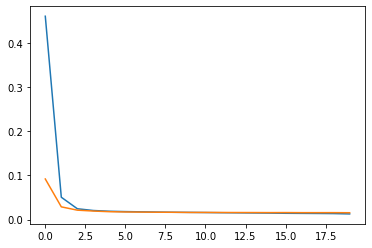

In [22]:
history.history['loss']
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

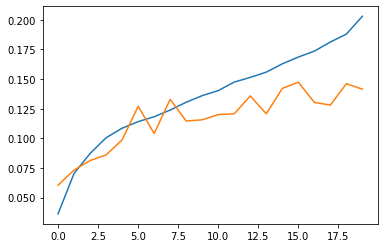

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [24]:
def new_log_loss(y_tr, y_pr):
  y_tr = y_tr.astype(np.float16)
  y_pr = y_pr.astype(np.float16)
  N, M = y_pr.shape
  loss = []

  for m in range(M):
    loss_temp = 0
    for i in range(N):
      loss_temp -= ((y_tr[i,m]*np.log(y_pr[i,m]))+((1.0-y_tr[i,m])*np.log(1.0-y_pr[i,m])))
    loss_temp = loss_temp/N
    loss.append(loss_temp)
    cleaned_loss = [l for l in loss if str(l) != 'nan']
  return np.mean(cleaned_loss)


In [25]:
log_loss = 0.0
count = 0
y_tr_temp = y_train.to_numpy()
for model in models:
  y_pred = model.predict(x_train)
  log_loss = log_loss + new_log_loss(y_tr_temp, y_pred)
  count = count + 1
print("Log loss: ", str(log_loss/count))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in half_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in half_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # 

Log loss:  0.020168779337023397
